## Import packages

In [ ]:
# If using Google Colab, uncomment the following line
# !pip install rasterio

import sys
print(sys.version)  # Print Python version in use

import numpy as np                                   # Array operations
import matplotlib.pyplot as plt                      # Plotting library
import torch                                         # Main PyTorch library
import os                                            # Operating system utilities
import pandas as pd                                  # Data manipulation
import rasterio                                      # Geospatial raster data
import folium                                        # Interactive maps

from datetime import datetime, timedelta             # Date/time utilities
from pyproj import Transformer                       # Coordinate transformation
from rasterio.plot import show                        # Plot raster data	

import deepSSF_model                                 # Import the .py file containing the deepSSF model                                          

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]


## Import the GPS data

We only use this for selecting a spatial extent for the area we want to predict over.

In [7]:
# select the id of that data that the model was trained on
buffalo_id = 2005
n_samples = 10297 # 2005 has 10297 samples

# Specify the path to your CSV file
csv_file_path = f'../buffalo_local_data_id/buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

         ta    cos_ta         x_min         x_max         y_min         y_max  \
0  1.367942  0.20

# Importing spatial data

Instead of importing the stacks of local layers (one for each step), here we want to import the spatial covariates for the extent we want to simulate over. We use an extent that covers all of the observed locations, which refer to as the 'landscape'.

## NDVI

We have monthly NDVI layers for 2018 and 2019, which we import as a stack. The files don't import with a time component, so we will use a function further down that indexes them correctly.

In [8]:
# for monthly NDVI
file_path = '../mapping/cropped rasters/ndvi_monthly.tif'

# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    ndvi_landscape = src.read([i for i in range(1, src.count + 1)])
    # Get the metadata of the raster
    ndvi_meta = src.meta
    raster_transform = src.transform

    # Print the metadata to check for time component
    print("Metadata:", ndvi_meta)

    # Check for specific time-related metadata
    if 'TIFFTAG_DATETIME' in src.tags():
        print("Time component found:", src.tags()['TIFFTAG_DATETIME'])
    else:
        print("No explicit time component found in metadata.")

# the rasters don't contain a time component, so we will use a function later to index the layers correctly

Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 24, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
No explicit time component found in metadata.


### Prepare the NDVI data

There are a few things we need to do to prepare the landscape layers. 

First, we need to ensure that there are no NA values in the data. For NDVI we will replace any NA values with -1 (which denotes water), as in our case that is typically why they were set to NA. 

Secondly, the model expects the covariates to on *the same scale as the training data*. We will therefore scale the NDVI data using the same max and min scaling parameters as the training data. To get these, there are some min and max print statements in the `deepSSF_train.ipynb` script. When we plot the NDVI data below we will see that the values will no longer range from 0 to 1, which is because there are values in the landscape layers that are outside of the range of the training data.

NDVI metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 24, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}


Affine transformation parameters:
| 25.00, 0.00, 0.00|
| 0.00,-25.00,-1406000.00|
| 0.00, 0.00, 1.00|


Shape of the raster:
(24, 2280, 2400)


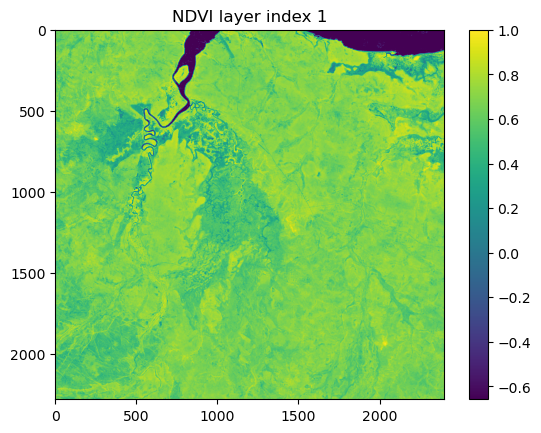

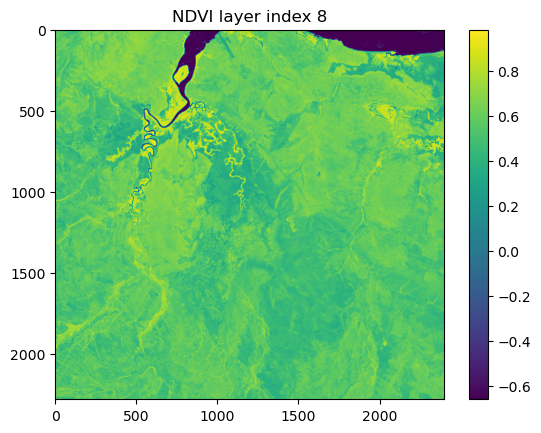

In [9]:
# Check the coordinate reference system
print("NDVI metadata:")
print(ndvi_meta)
print("\n")

# Have a look at the affine transformation parameters that are used to convert pixel 
# coordinates to geographic coordinates and vice versa
print("Affine transformation parameters:")
print(raster_transform)
print("\n")

# Check the shape (layers, row, columns) of the raster
print("Shape of the raster:")
print(ndvi_landscape.shape)

# Replace NaNs in the original array with -1, which represents water
ndvi_landscape = np.nan_to_num(ndvi_landscape, nan=-1.0)

# from the stack of local layers (training data)
ndvi_max = 0.8220
ndvi_min = -0.2772

# Convert the numpy array to a PyTorch tensor
ndvi_landscape_tens = torch.from_numpy(ndvi_landscape)

# Normalizing the data
ndvi_landscape_norm = (ndvi_landscape_tens - ndvi_min) / (ndvi_max - ndvi_min)

# Show two example layers of the scaled NDVI data
layer_index = 1
plt.imshow(ndvi_landscape_norm[layer_index,:,:].numpy())
plt.colorbar()  
plt.title(f'NDVI layer index {layer_index}')
plt.show()

layer_index = 8
plt.imshow(ndvi_landscape_norm[layer_index,:,:].numpy())
plt.colorbar()  
plt.title(f'NDVI layer index {layer_index}')
plt.show()

## Canopy cover

Canopy cover is just a single static layer.

In [10]:
# Path to the canopy cover raster file
file_path = '../mapping/cropped rasters/canopy_cover.tif'

# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    canopy_landscape = src.read(1)
    # Get the metadata of the raster
    canopy_meta = src.meta

### Prepare the canopy cover data

As with the NDVI data, we need to ensure that there are no NA values in the data. 

As the canopy cover values in the landscape layer are within the same range as the training data, we see that the values range from 0 to 1.

Canopy metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}


Shape of canopy raster:
(2280, 2400)


Number of NA values in the canopy raster:
0


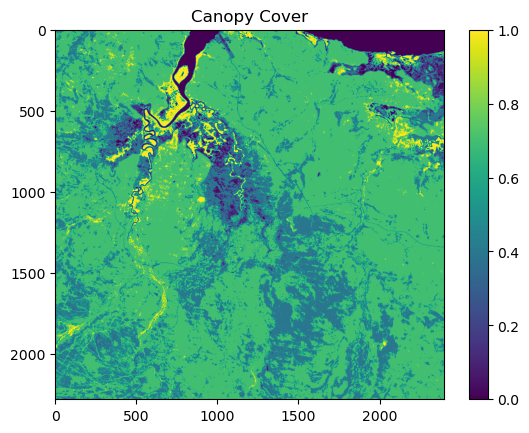

In [11]:
# Check the canopy metadata:
print("Canopy metadata:")
print(canopy_meta)
print("\n")

# Check the shape (rows, columns) of the canopy raster:
print("Shape of canopy raster:")
print(canopy_landscape.shape)
print("\n")

# Check for NA values in the canopy raster:
print("Number of NA values in the canopy raster:")
print(np.isnan(canopy_landscape).sum())

# Define the maximum and minimum canopy values from the stack of local layers:
canopy_max = 82.5000
canopy_min = 0.0

# Convert the canopy data from a NumPy array to a PyTorch tensor:
canopy_landscape_tens = torch.from_numpy(canopy_landscape)

# Normalise the canopy data:
canopy_landscape_norm = (canopy_landscape_tens - canopy_min) / (canopy_max - canopy_min)

# Visualise the normalised canopy cover:
plt.imshow(canopy_landscape_norm.numpy())
plt.colorbar()
plt.title('Canopy Cover')
plt.show()


## Herbaceous vegetation

In [12]:
# Path to the herbaceous vegetation raster file
file_path = '../mapping/cropped rasters/veg_herby.tif'

# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    herby_landscape = src.read(1)
    # Get the metadata of the raster
    herby_meta = src.meta

Herbaceous metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}


Shape of herbaceous raster:
(2280, 2400)


Number of NA values in the herbaceous vegetation raster:
0


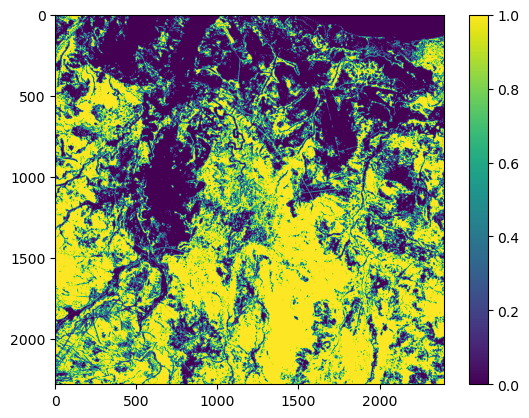

In [13]:
# Check the herbaceous metadata:
print("Herbaceous metadata:")
print(herby_meta)
print("\n")

# Check the shape (rows, columns) of the herbaceous raster:
print("Shape of herbaceous raster:")
print(herby_landscape.shape)
print("\n")

# Check for NA values in the herby raster:
print("Number of NA values in the herbaceous vegetation raster:")
print(np.isnan(herby_landscape).sum())

# Define the maximum and minimum herbaceous values from the stack of local layers:
herby_max = 1.0
herby_min = 0.0

# Convert the herbaceous data from a NumPy array to a PyTorch tensor:
herby_landscape_tens = torch.from_numpy(herby_landscape)

# Normalize the herbaceous data:
herby_landscape_norm = (herby_landscape_tens - herby_min) / (herby_max - herby_min)

# Visualize the normalised herbaceous cover:
plt.imshow(herby_landscape_norm.numpy())
plt.colorbar()
plt.show()


## Slope

In [14]:
# Path to the slope raster file
file_path = '../mapping/cropped rasters/slope.tif'

# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    slope_landscape = src.read(1)
    # Get the metadata of the raster
    slope_meta = src.meta

Slope metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}


Shape of slope landscape raster:
(2280, 2400)


Number of NA values in the slope raster:
0


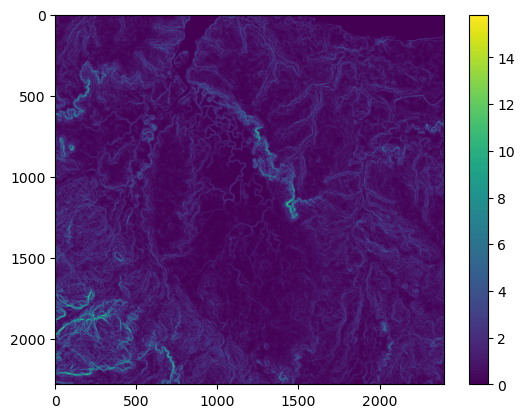

In [ ]:
# Check the slope metadata:
print("Slope metadata:")
print(slope_meta)
print("\n")

# Check the shape (rows, columns) of the slope landscape raster:
print("Shape of slope landscape raster:")
print(slope_landscape.shape)
print("\n")

# Check for NA values in the slope raster:
print("Number of NA values in the slope raster:")
print(np.isnan(slope_landscape).sum())

# Replace NaNs in the slope array with 0.0:
slope_landscape = np.nan_to_num(slope_landscape, nan=0.0)

# Define the maximum and minimum slope values from the stack of local layers:
slope_max = 12.2981
slope_min = 0.0006

# Convert the slope landscape data from a NumPy array to a PyTorch tensor:
slope_landscape_tens = torch.from_numpy(slope_landscape)

# Normalize the slope landscape data:
slope_landscape_norm = (slope_landscape_tens - slope_min) / (slope_max - slope_min)

# Visualize the slope landscape (note: displaying the original tensor, not the normalised data):
plt.imshow(slope_landscape_tens.numpy())
plt.colorbar()
plt.show()


### Convert between numpy array and raster

To check that we can go back and forth between numpy arrays (with pixel coordinates) and rasters (with geographic coordinates), we will convert the slope numpy array to a raster. 

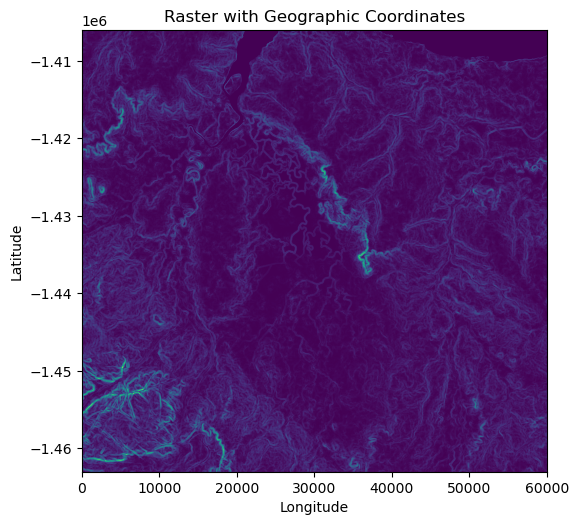

In [20]:
# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(6, 6))

# Convert the slope_landcape (numpy array) to a raster and plot with the rasterio library
rasterio.plot.show(slope_landscape, transform=raster_transform, ax=ax, cmap='viridis')

# Set the title and labels
ax.set_title('Raster with Geographic Coordinates')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

# Subset function (with padding)

Now that we have our landscape layers imported, we need a way to crop out the local layers that can be fed into the deepSSF model as covariates.

Also, if our simulated individual goes off the edge of the landscape, we need to pad the landscape layers, in this case we will use values of -1 (which corresponds to water for NDVI and should be avoided) as the deepSSF model can't handle NA values.

We'll pick a location near the edge to illustrate this.

In [327]:
# Define geographic coordinates (x: easting/longitude, y: northing/latitude) near the edge
x, y = 5.9e4, -1.447e6
print(x, y)

# Convert geographic coordinates to pixel coordinates using the inverse transform
px, py = ~raster_transform * (x, y)

# Round the resulting pixel coordinates to the nearest integers
px, py = int(round(px)), int(round(py))

# Output the computed pixel coordinates
print(px, py)

59000.0 -1447000.0
2360 1640


Crop out the local layer, and pad with 0s if necessary.

In [328]:
window_size = 101  # Define the size of the local covariates (should be the same as the model input size)
# Calculate half the window size for centering 
# (the double slash // is integer or floor division, which rounds down to the nearest whole number)
half_window = window_size // 2 

# Determine the starting and ending indices of the window around the centre point (py, px)
row_start = py - half_window
row_stop = py + half_window + 1 # add one back on to offset the floor division
col_start = px - half_window
col_stop = px + half_window + 1 # add one back on to offset the floor division

# Create an array for the windowed subset, initialised with -1
subset = np.full((window_size, window_size), -1, dtype=slope_landscape.dtype)

# Find the valid region within the original array boundaries
valid_row_start = max(0, row_start)
valid_row_stop = min(slope_landscape.shape[0], row_stop)
valid_col_start = max(0, col_start)
valid_col_stop = min(slope_landscape.shape[1], col_stop)

# Calculate where this valid region maps into the subset array
subset_row_start = valid_row_start - row_start
subset_row_stop = subset_row_start + (valid_row_stop - valid_row_start)
subset_col_start = valid_col_start - col_start
subset_col_stop = subset_col_start + (valid_col_stop - valid_col_start)

# Copy the valid part of the raster into the corresponding region of the subset array
subset[subset_row_start:subset_row_stop, subset_col_start:subset_col_stop] = \
    slope_landscape[valid_row_start:valid_row_stop, valid_col_start:valid_col_stop]


Plot the local layer (of slope) in pixel coordinates, which will be 101 x 101 pixels.

Try with different coordinates above to crop out different local layers. Only the centre location is required, which is always the current location of the individual (and we are using the model to predict the next step).

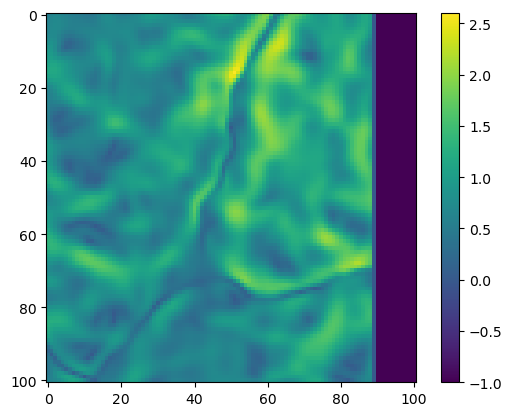

In [329]:
# plot the subset
plt.imshow(subset, cmap='viridis')
plt.colorbar()
plt.show()

## Subset function

Turn the subset code into a function for using in the simulations, although here we are operating on Pytorch tensors rather than numpy arrays, as that is what Pytorch uses.

We have saved this function in the `deepSSF_utils.py` script for use in other scripts.

In [334]:
def subset_raster_with_padding_torch(raster_tensor, x, y, window_size, transform):
    # Convert geographic coordinates to pixel coordinates using the inverse transform.
    px, py = ~transform * (x, y)
    
    # Round the pixel coordinates to the nearest integers.
    px, py = int(round(px)), int(round(py))
    
    # Compute half the window size to determine the extent around the central pixel.
    half_window = window_size // 2
    
    # Determine the boundaries of the window centred on the pixel coordinates.
    row_start = py - half_window
    row_stop = py + half_window + 1
    col_start = px - half_window
    col_stop = px + half_window + 1
    
    # Initialise a tensor for the subset with a padding value of -1.0.
    subset = torch.full((window_size, window_size), -1.0, dtype=raster_tensor.dtype)
    
    # Determine the valid region of the raster that falls within the window boundaries.
    valid_row_start = max(0, row_start)
    valid_row_stop = min(raster_tensor.shape[0], row_stop)
    valid_col_start = max(0, col_start)
    valid_col_stop = min(raster_tensor.shape[1], col_stop)
    
    # Calculate the corresponding region within the subset tensor.
    subset_row_start = valid_row_start - row_start
    subset_row_stop = subset_row_start + (valid_row_stop - valid_row_start)
    subset_col_start = valid_col_start - col_start
    subset_col_stop = subset_col_start + (valid_col_stop - valid_col_start)
    
    # Copy the valid region from the raster tensor into the appropriate section of the subset tensor.
    subset[subset_row_start:subset_row_stop, subset_col_start:subset_col_stop] = \
        raster_tensor[valid_row_start:valid_row_stop, valid_col_start:valid_col_stop]
    
    # Return the subset along with the starting column and row indices of the window.
    return subset, col_start, row_start


### Testing the subset function

Use the subset function to crop out the local layers for all covariates. Try different locations using the x and y coordinates, which are in geographic coordinates (x = easting/longitude, y = northing/latitude).

Text(0.5, 1.0, 'Slope Subset')

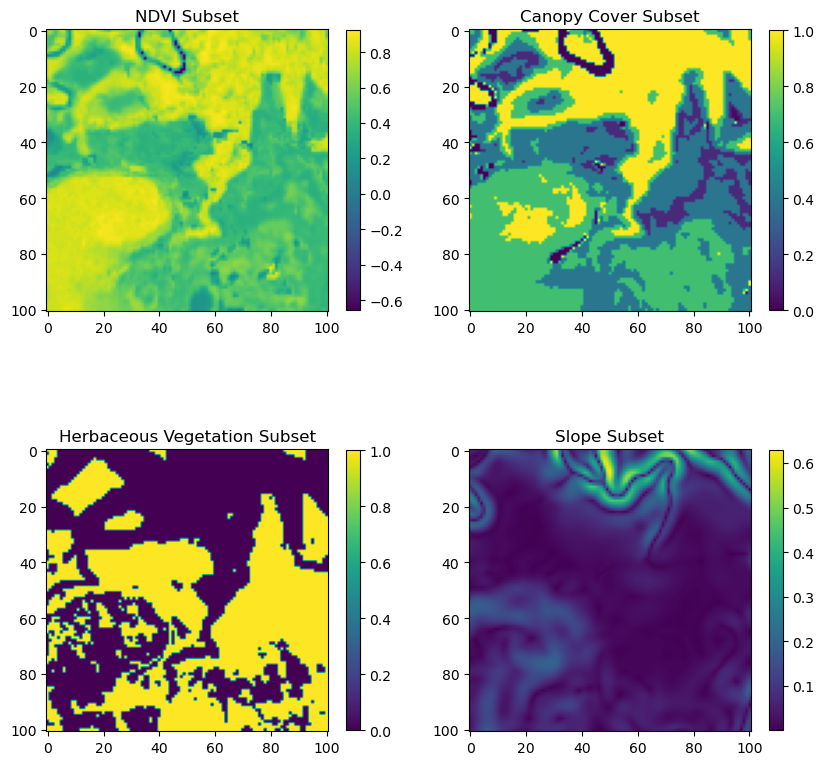

In [335]:
x = 5.8e4  # Set the easting coordinate
y = -1.425e6  # Set the northing coordinate
window_size = 101  # Define the size of the window to extract

which_ndvi = 1  # Select the NDVI layer index

# Extract subsets from various raster layers using the custom function.
# Each call centres the window at the specified (x, y) location and applies padding where necessary.
ndvi_subset, origin_x, origin_y = subset_raster_with_padding_torch(ndvi_landscape_norm[which_ndvi, :, :], 
                                                                   x, y, window_size, raster_transform)
canopy_subset, origin_x, origin_y = subset_raster_with_padding_torch(canopy_landscape_norm, 
                                                                     x, y, window_size, raster_transform)
herby_subset, origin_x, origin_y = subset_raster_with_padding_torch(herby_landscape_norm, 
                                                                    x, y, window_size, raster_transform)
slope_subset, origin_x, origin_y = subset_raster_with_padding_torch(slope_landscape_norm, 
                                                                    x, y, window_size, raster_transform)

# Create a 2x2 grid of subplots with a fixed figure size.
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the NDVI subset.
im0 = axs[0, 0].imshow(ndvi_subset.numpy(), cmap='viridis')
fig.colorbar(im0, ax=axs[0, 0], shrink=0.8)
axs[0, 0].set_title('NDVI Subset')

# Plot the Canopy Cover subset.
im1 = axs[0, 1].imshow(canopy_subset.numpy(), cmap='viridis')
fig.colorbar(im1, ax=axs[0, 1], shrink=0.8)
axs[0, 1].set_title('Canopy Cover Subset')

# Plot the Herbaceous Vegetation subset.
im2 = axs[1, 0].imshow(herby_subset.numpy(), cmap='viridis')
fig.colorbar(im2, ax=axs[1, 0], shrink=0.8)
axs[1, 0].set_title('Herbaceous Vegetation Subset')

# Plot the Slope subset.
im3 = axs[1, 1].imshow(slope_subset.numpy(), cmap='viridis')
fig.colorbar(im3, ax=axs[1, 1], shrink=0.8)
axs[1, 1].set_title('Slope Subset')


# Load the model

## Set the device for the model

In [4]:
# run on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


## Define the parameters for the model

Here we enter the specific parameter values and hyperparameters for the model. 
These are the values that will be used to instantiate the model.

In [5]:
# Define the parameters for the model
params_dict = {"batch_size": 32, #number of samples in each batch
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": 4 + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 12, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1, #the proportion of nodes that are dropped out in the dropout layers
               "device": device
               }

As described in the `deepSSF_train.ipynb` script, we saved the model definition into a file named `deepSSF_model.py`. We can instantiate the model by importing the file (which was done when importing other packages) and calling the classes parameter dictionary from that script.

In [6]:
params = deepSSF_model.ModelParams(params_dict)
model = deepSSF_model.ConvJointModel(params).to(device)
print(model)

ConvJointModel(
  (scalar_grid_output): Scalar_to_Grid_Block()
  (conv_habitat): Conv2d_block_spatial(
    (conv2d): Sequential(
      (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (conv_movement): Conv2d_block_toFC(
    (conv2d): Sequential(
      (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fcn_movement_all): FCN_block_all_movement(
    (ffn): Sequential(
      (0): Linear(in_features=2500, out_features=128, b

## Load the model weights

In [44]:
# # load the model weights
# print(model.state_dict())
model.load_state_dict(torch.load(f'model_checkpoints/checkpoint_CNN_buffalo2005_2025-02-04.pt', 
                                 map_location=torch.device('cpu'),
                                 weights_only=True))
# print(model.state_dict())
# model.eval()

<All keys matched successfully>

# Setup simulation parameters

To get the simulation running we need a few extra functions. 

Firstly, we need to index the NDVI layers correctly, based on the time of the simulated location. We'll do this by creating a function that takes day of the year of the simulated location and returns the correct index for the NDVI layers.

Recall that Python indexes from 0, so when the month_index is equal to 2 for instance, this will index the third layer, which is for March.

In [48]:
# Create a mapping from day of the year to month index
def day_to_month_index(day_of_year):
    # Calculate the year and the day within that year
    base_date = datetime(2018, 1, 1) # base date for the calculation, which is when the NDVI layers start
    date = base_date + timedelta(days=int(day_of_year) - 1)
    year_diff = date.year - base_date.year
    month_index = (date.month - 1) + (year_diff * 12)  # month index (0-based, accounting for year change)
    return month_index

yday = 70 # day of the year, which is March 11th
month_index = day_to_month_index(yday)
print(month_index)

2


## Stack the covariate subset layers

For testing the model.

In [337]:
# Stack the channels along a new axis
subset_stack = torch.stack([ndvi_subset, 
                            canopy_subset, 
                            herby_subset, 
                            slope_subset], 
                            dim=0)
x1 = subset_stack
x1 = x1.unsqueeze(0)
print(x1.shape)

torch.Size([1, 4, 101, 101])


## Additional data

We also need to provide the model with the temporal covariates (hour of day and the day of the year). We will do that by creating a vector of length `n_steps` for each of these.

For the bearing we will initialise a vector of 0s, but when the model is run we will update the bearings based on the predicted steps. We will then use the bearing of the last step to predict the bearing of the next step (by estimating the turning angle as a deviation from that bearing).

We'll only index a single time step when testing the function below, but we'll create the vectors for illustration.

In [338]:
# Define the number of simulation steps.
n_steps = 100

# Create an hour-of-day sequence and repeat it until it reaches n_steps.
hour_t2 = np.resize(range(24), n_steps)

# Convert hour-of-day values into sine and cosine components.
hour_t2_sin = np.sin(2 * np.pi * hour_t2 / 24)
hour_t2_cos = np.cos(2 * np.pi * hour_t2 / 24)

# Create a day-of-year sequence (each day repeated 24 times) and resize to n_steps.
yday_sequence = np.repeat(range(yday, 365), 24)
yday_t2 = np.resize(yday_sequence, n_steps)

# Convert day-of-year values into sine and cosine components.
yday_t2_sin = np.sin(2 * np.pi * yday_t2 / 365)
yday_t2_cos = np.cos(2 * np.pi * yday_t2 / 365)

# Initialise a bearing vector with zeroes for all simulation steps, 
# which will be updated during the simulation.
bearing = np.repeat(0., n_steps)

# Convert the arrays to PyTorch tensors.
hour_t2_tensor = torch.tensor(hour_t2).float()
hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
yday_t2_tensor = torch.tensor(yday_t2).float()
yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()
bearing = torch.tensor(bearing).float()

# Stack the sine and cosine tensors along a new dimension to form the temporal feature tensor.
x2_full = torch.stack((hour_t2_sin_tensor, 
                       hour_t2_cos_tensor, 
                       yday_t2_sin_tensor, 
                       yday_t2_cos_tensor), dim=1)

# Print the shape of the tensor: (number of steps, number of features).
print(x2_full.shape)

# Display the temporal features for a specific time step (e.g. index 59).
print(f'Temporal information for a single step: {x2_full[59, :]}')


torch.Size([100, 4])
Temporal information for a single step: tensor([ 0.2588, -0.9659,  0.9456,  0.3253])


### Functions to recover the hour and yday

Occasionally we will want to recover the hour and day of the year from the sine and cosine terms, so we create a few helper functions to do this.

We have saved these functions in the `deepSSF_utils.py` script for use in other scripts.

In [339]:
def recover_hour(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    hour = (24 * theta) / (2 * np.pi) % 24
    return hour


def recover_yday(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    yday = (365 * theta) / (2 * np.pi) % 365
    return yday

## Test the model on the subset layers

Now we have the covariates ready, we can test the model on them.

In [340]:
# Select a specific time step to test the model, 
# which just indexes the temporal features in this case
step = 17

# Run the model with the selected input tensors
# Create some extra dimensions to match the model input shape
test = model((x1, x2_full[step,:].unsqueeze(0), bearing[step].unsqueeze(0).unsqueeze(0)))
print(test.shape)

torch.Size([1, 101, 101, 2])


### View the model output

We first check what the hour and yday values were that were inputted to the model, and then plot the habitat selection, movement and next-step predictions from the model.

As convolution filters produce artifacts at the edges of the image, we will crop the habitat selection predictions to remove these. We do this as those edge values are often quite different to the rest of the prediction outputs and change the colour scale, and we only do this when plotting the habitat selection and next-step predictions.

We will also crop out the padding we added to the landscape layers at the edges of the landscape covariates. This we also do during the simulation, as we don't want cells outside the extent of the landscape to be selected as the next step, i.e., we create a 'hard' or 'reflective' boundary.

The hour of the step is 17
The day of the year of the step is 70


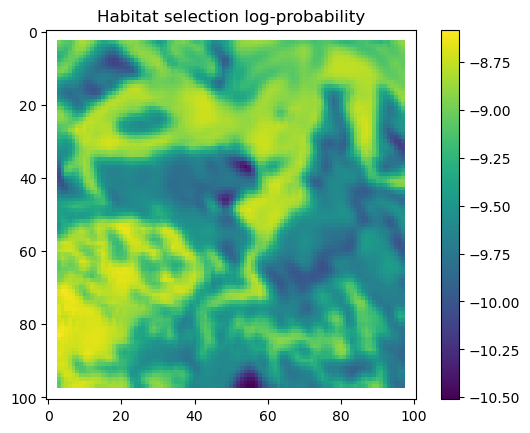

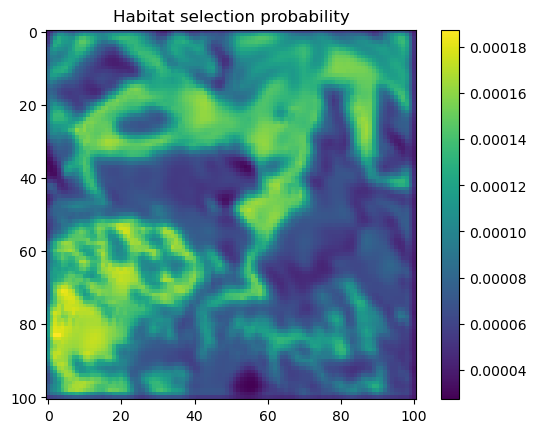

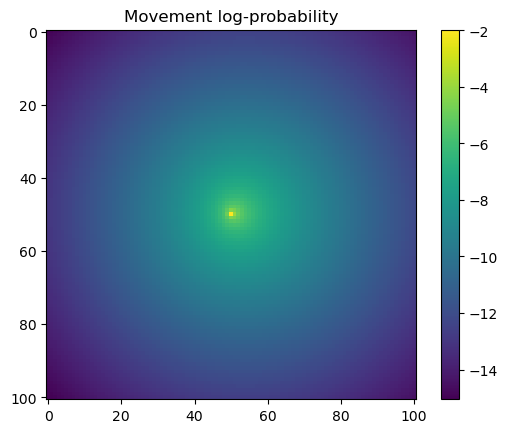

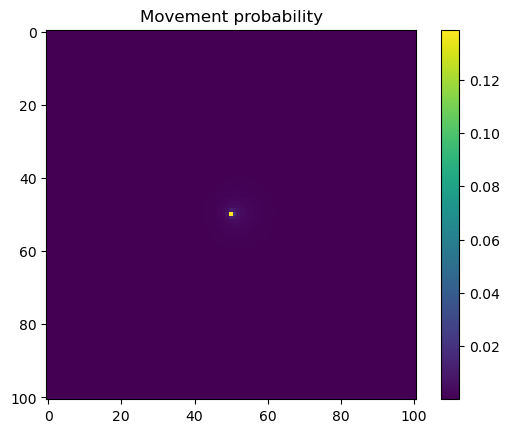

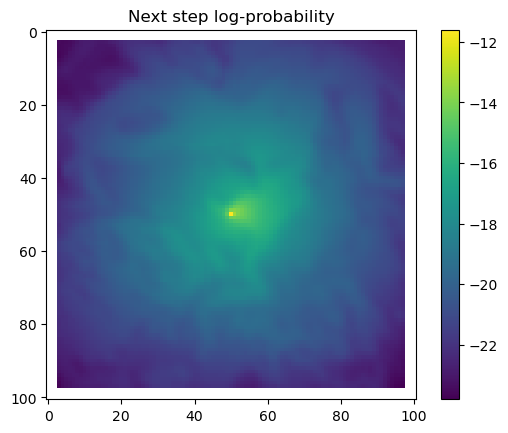

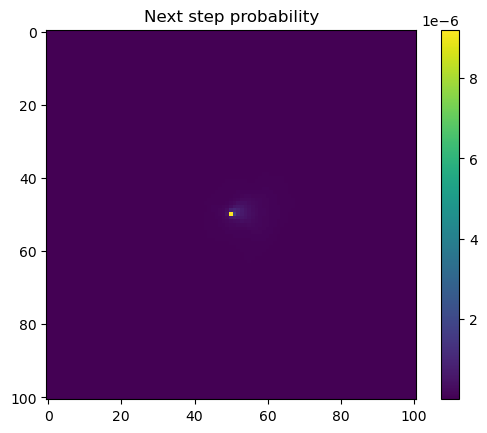

In [341]:
# Extract the temporal features for the specified step and convert to a NumPy array.
x2_step = x2_full[step, :].detach().numpy()

# Unpack the sine and cosine components for both hour and day-of-year.
hour_t2_sin, hour_t2_cos, yday_t2_sin, yday_t2_cos = x2_step

# Recover and print the hour value for the step using the sine and cosine components.
hour_t2 = recover_hour(hour_t2_sin, hour_t2_cos)
print(f'The hour of the step is {round(hour_t2)}')

# Recover and print the day-of-year value for the step using the sine and cosine components.
yday_t2 = recover_yday(yday_t2_sin, yday_t2_cos)
print(f'The day of the year of the step is {round(yday_t2)}')

# Extract model predictions from the output tensor.
# hab_density: predicted habitat density; move_density: predicted movement density.
hab_density = test.detach().numpy()[0, :, :, 0]  # habitat density
move_density = test.detach().numpy()[0, :, :, 1]   # movement density

# Compute the next step probability by summing habitat and movement densities.
next_step = hab_density + move_density

# Create border masks for the x and y coordinates to control the colour scale.
x_mask = np.ones_like(hab_density)
y_mask = np.ones_like(hab_density)

# Mask out the edge cells by setting them to negative infinity.
x_mask[:, :3] = -np.inf
x_mask[:, 98:] = -np.inf
y_mask[:3, :] = -np.inf
y_mask[98:, :] = -np.inf

# Create an edge mask using the NDVI subset as a template.
# Replace padding values (-1) with NaN so they do not affect visualisation or sampling.
extent_mask = ndvi_subset
extent_mask = torch.where(extent_mask == -1, torch.tensor(float('nan')), 1).numpy()

# Apply the masks to the probability surfaces
hab_density = hab_density * extent_mask
move_density = move_density * extent_mask
next_step = next_step * extent_mask

# Plot the habitat selection log-probability after applying the border and edge masks.
plt.imshow(hab_density * x_mask * y_mask)
plt.colorbar()
plt.title('Habitat selection log-probability')
plt.show()

# Plot the habitat selection probability
plt.imshow(np.exp(hab_density))
plt.colorbar()
plt.title('Habitat selection probability')
plt.show()

# Plot the movement log-probability
plt.imshow(move_density)
plt.colorbar()
plt.title('Movement log-probability')
plt.show()

# Plot the movement probability
plt.imshow(np.exp(move_density))
plt.colorbar()
plt.title('Movement probability')
plt.show()

# Plot the next step log-probability with the masks applied.
plt.imshow(next_step * x_mask * y_mask)
plt.colorbar()
plt.title('Next step log-probability')
plt.show()

# Plot the next step probability.
plt.imshow(np.exp(next_step))
plt.colorbar()
plt.title('Next step probability')
plt.show()


## Sample from the probability surface

I.e., choose the individual's next step

Sum of probability values:      0.9999999999999999
Sampled probability values:     0.0019719361713782337
Sampled coordinates:            (46, 57)


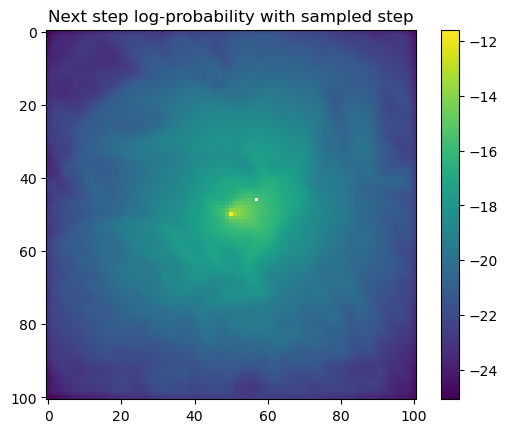

In [342]:
# sample from the array values
next_step_exp = np.exp(next_step)
# replace NaNs with 0 (which have no probability of being selected)
next_step_exp = np.nan_to_num(next_step_exp, nan=0.)
# normalise the array to sum to 1
next_step_exp = next_step_exp/np.sum(next_step_exp)
print(f'Sum of probability values:      {np.sum(next_step_exp)}') # should be 1

# Flatten the probability surface into a vector (1D array)
flat_prob_surface = next_step_exp.flatten()
# print(flat_prob_surface)

# Generate the corresponding cell indices for the flattened array
indices = np.arange(flat_prob_surface.size)
# print(indices)

# Sample from the flattened probability surface
sampled_index = np.random.choice(indices, p=flat_prob_surface)
# print(sampled_index)

# Print the probability of the sampled index
print(f'Sampled probability values:     {flat_prob_surface[sampled_index]}')

# Convert the sampled index back to 2D coordinates
sampled_coordinates = np.unravel_index(sampled_index, next_step_exp.shape)
print(f'Sampled coordinates:            {sampled_coordinates}')

# Create a copy of the next step probability surfaces for plotting
# The log-probability surface is used for visualisation as it's more informative
step_log_prob = next_step.copy()
# The probability surface is used for sampling, but it's not as visually informative
# step_log_prob = next_step_exp.copy()

# Set the pixel of the next step, which is at (x, y) to -inf
step_log_prob[sampled_coordinates] = -np.inf

# Plot the next step log-probability with the sampled step highlighted
plt.imshow(step_log_prob)
plt.colorbar()
plt.title('Next step log-probability with sampled step')
plt.show()

## Sample a number of next steps

To get an idea of the distribution of next-steps (from the same starting location), we can loop over the sampling process and block out the selected steps.

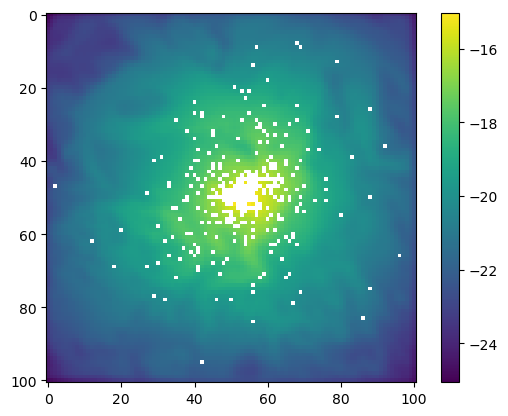

In [343]:
for i in range(500):

    # Sample from the flattened probability surface
    sampled_index = np.random.choice(indices, p=flat_prob_surface)

    # Convert the sampled index back to 2D coordinates
    sampled_coordinates = np.unravel_index(sampled_index, next_step_exp.shape)

    # Set the pixel of the next step, which is at (x, y) to -inf
    step_log_prob[sampled_coordinates] = -np.inf

plt.imshow(step_log_prob)
plt.colorbar()
plt.show()

## Return sampled point to geographic coordinates

When simulating, we don't want to just the pixel values (as they are in reference to the local layer), but we want to return the geographic coordinates of the next step and store those.

In [345]:
print(f'Starting location in geographic coordinates:                 {x ,y}')
print(f'Starting location in landscape layer pixel coordinates:      {px, py}')
print(f'Sampled next step location (local layer pixel coordinates):  {sampled_coordinates}')
print(f'landscape pixel locations at the origin of the local layer:  {row_start, col_start}')

# Add the sampled coordinates to the landscape pixel locations at the origin of the local layer
# THE Y COORDINATE (row) COMES FIRST
new_px = origin_x + sampled_coordinates[1]
new_py = origin_y + sampled_coordinates[0]

print(f'landscape pixel coordinates of the sampled next step:        {new_px, new_py}')

# Convert landscape pixel coordinates to geographic coordinates
new_x, new_y = raster_transform * (new_px, new_py)

print(f'Landscape geograhic coordinates at the next step:            {new_x, new_y}')

Starting location in geographic coordinates:                 (58000.0, -1425000.0)
Starting location in landscape layer pixel coordinates:      (2360, 1640)
Sampled next step location (local layer pixel coordinates):  (53, 34)
landscape pixel locations at the origin of the local layer:  (1590, 2310)
landscape pixel coordinates of the sampled next step:        (2304, 763)
Landscape geograhic coordinates at the next step:            (57600.0, -1425075.0)


# Next-step function

Now we have all of the pieces working, we can put them together into function that predicts the next step of the simulated individual. We can then loop over the function to create trajectories.

The next-step function will take the following inputs:
- environmental rasters at the landscape level,
- the scalar covariates to be turned into grids (temporal covariates in our case),
- the previous bearing to predict the turning angle from,
- the size of the local layer to crop out,
- the current location of the simulated individual,
- the raster transformation to convert between pixel and geographic coordinates.

**Adding jitter to the next step**  
As location of the next step is a particular cell (which are 25 m x 25 m), we also have an additional component in the function that adds an element of randomness to where in the cell the next step is. This prevents the location of the next step from being in exactly the same location as the current step (which would lead to a null bearing and 0 step length), and prevents an artificial grid-like pattern from emerging in the simulated trajectories. As all of the probability values are exactly the same within a cell, this is analogous to the process of simulating from an SSF, where continuous step lengths and turning angles are drawn from their distributions, which land somewhere in a particular cell. However, the difference is that the probability values for the movement kernel in an SSF are still continuous, whereas in the deepSSF model they are discrete (due to calculating the movement probability for each cell). This may lead to artifacts for steps very close to the current location, as the Gamma distribution has high probability near 0.

We 'jitter' the point by adding a small amount of noise in the x and y direction. This small amount is drawn from a 2D (uncorrelated) normal distribution with a mean of 0 and a standard deviation of 6.5 m, such that about 95% of the jittered points will fall within the 25 m x 25 m cell. If the jittered point falls outside of the cell, we re-sample the jittered point until it falls within the cell. 

This could have also been a uniform distribution between -12.5 and 12.5 in the x and y directions, but we chose a normal distribution as for the centre cell we still want it to be close to 0. This was a modelling choice and different choices here will have slightly different effects (although mainly on the step length and turning angle distributions). The cell that was selected, which becomes the cell to start the next step from, will be the same.

In [348]:
def simulate_next_step(landscape_raster_tensors, 
                       scalars_to_grid,
                       bearing,
                       window_size, 
                       x_loc, 
                       y_loc,
                       landscape_raster_transform):
    
    # Extract subsets from the landscape rasters
    results = [subset_raster_with_padding_torch(raster_tensor, 
                                                x=x_loc, 
                                                y=y_loc, 
                                                window_size=window_size, 
                                                transform=landscape_raster_transform) 
                                                for raster_tensor in landscape_raster_tensors]
    
    # Unpacking the results
    subset_rasters_tensors, origin_xs, origin_ys = zip(*results)
    # print(subset_rasters_tensors)
    
    # Stack the processed tensors along a new dimension (e.g., dimension 0)
    x1 = torch.stack(subset_rasters_tensors, dim=0)
    x1 = x1.unsqueeze(0)
    # print(x1.shape)

    # Pull out the NDVI layer to get where is was set to -1 (outside the landscape extent)
    ndvi_local_layer = x1[0, 0, :, :]

    # create masking layer to remove outside of the extent
    mask = torch.where(ndvi_local_layer == -1, torch.tensor(float('nan')), 1)
    
    # Set the scalar values as the x2 model input
    x2 = scalars_to_grid

    # Set the bearing values as the x3 model input
    x3 = bearing

    test = model((x1, x2, x3))
    # print(test.shape) # Debugging print - should be (1, 101, 101, 2)

    hab_log_prob = test[:, :, :, 0]
    move_log_prob = test[:, :, :, 1]

    step_log_prob = (hab_log_prob + move_log_prob)
    step_log_prob = step_log_prob * mask

    hab_log_prob = hab_log_prob.squeeze()
    move_log_prob = move_log_prob.squeeze()
    step_log_prob = step_log_prob.squeeze()

    # sample from the array values
    step_prob = torch.exp(step_log_prob)
    step_prob = torch.nan_to_num(step_prob, nan=0.)
    step_prob_norm = step_prob/torch.sum(step_prob)
    # print(torch.sum(step_prob_norm)) # Debugging print - should be 1

    # Flatten the probability surface
    flat_step_prob_norm = step_prob_norm.flatten().detach().numpy()
    # print(flat_prob_surface) # Debugging print

    # Generate the corresponding indices for the flattened array
    indices = np.arange(flat_step_prob_norm.size)

    # Sample from the flattened probability surface
    sampled_index = np.random.choice(indices, p=flat_step_prob_norm)

    # Convert the sampled index back to 2D coordinates
    sampled_coordinates = np.unravel_index(sampled_index, step_prob_norm.shape)

    # THE Y COORDINATE COMES FIRST in the sampled pixel coordinates
    new_px = origin_xs[0] + sampled_coordinates[1]
    new_py = origin_ys[0] + sampled_coordinates[0]

    # Convert geographic coordinates to pixel coordinates
    new_x, new_y = raster_transform * (new_px, new_py)

    # Sample from a normal distribution with mean 0 and sd 6.5, 
    # which are the parameters where the cell contains ~ 95% of density
    # if it's outside the bounds of the cell, resample
    while True:
        jitter_x = np.random.normal(0, 6.5)
        if -12.5 <= jitter_x <= 12.5:
            break

    # Sample jitter for new_y and ensure it is within bounds
    while True:
        jitter_y = np.random.normal(0, 6.5)
        if -12.5 <= jitter_y <= 12.5:
            break

    # Add the valid jitter to new_x and new_y
    new_x = new_x + jitter_x
    new_y = new_y + jitter_y
    # print(new_x, new_y)

    # Return the new_x and new_y coordinates, 
    # the probability surfaces for optional plotting,
    # and the sampled coordinates (next step in local layer pixel coordinates)
    return new_x, \
           new_y, \
           hab_log_prob, \
           move_log_prob, \
           step_log_prob, \
           sampled_coordinates[1], \
           sampled_coordinates[0]


## Test the function

New location in local layer pixel coordinates:      (58, 49)
New location in geographic coordinates:             (31711.230214909534, -1429985.2047874588)


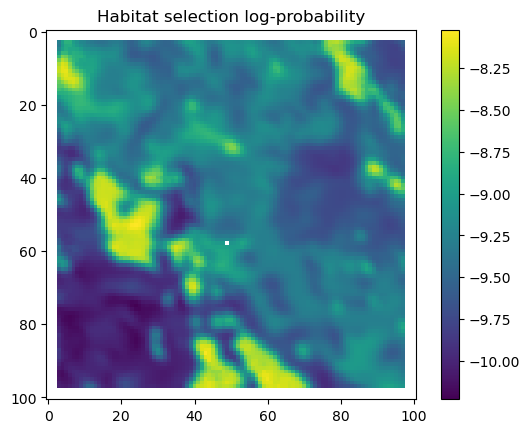

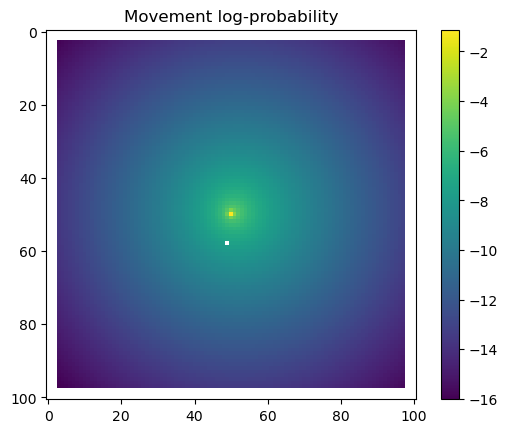

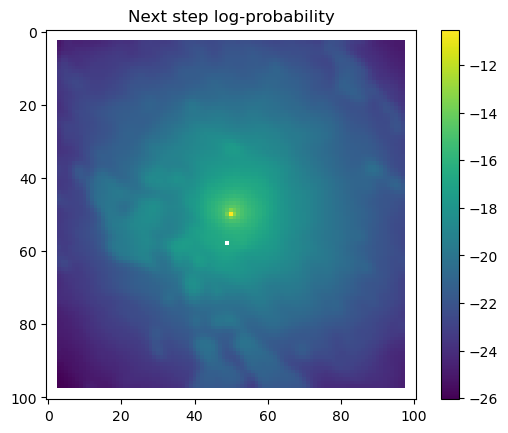

In [352]:
# Choose a location in the landscape
x = 3.15e4  # easting coordinate
y = -1.43e6  # northing coordinate

# Landscape scale rasters - select one of the NDVI layers
landscape_raster_list = [ndvi_landscape_norm[which_ndvi,:,:], 
                         canopy_landscape_norm, 
                         herby_landscape_norm, 
                         slope_landscape_norm]

# Select the temporal features for the specific step
x2 = x2_full[3,:].unsqueeze(0)
# print(x2.shape)

# Select the bearing for the specific step
bearing_step = bearing[3].unsqueeze(0).unsqueeze(0)
# print(bearing_step.shape)

test_outputs = simulate_next_step(landscape_raster_tensors=landscape_raster_list,
                                  scalars_to_grid=x2,
                                  bearing=bearing_step,
                                  window_size=101,
                                  x_loc=x,
                                  y_loc=y,
                                  landscape_raster_transform=raster_transform)

new_x, new_y, hab_log_prob, move_log_prob, step_log_prob, px, py = test_outputs

print(f'New location in local layer pixel coordinates:      {px, py}')
print(f'New location in geographic coordinates:             {new_x, new_y}')

# Set the pixel of the next step, which is at (px, py) to -inf
hab_log_prob[(px, py)] = -np.inf
move_log_prob[(px, py)] = -np.inf
step_log_prob[(px, py)] = -np.inf

# Plot the habitat selection log-probability after applying the border mask
plt.imshow(hab_log_prob.detach().numpy()[:,:] * x_mask * y_mask)
plt.colorbar()
plt.title('Habitat selection log-probability')
plt.show()

# Plot the movement log-probability
plt.imshow(move_log_prob.detach().numpy()[:,:] * x_mask * y_mask)
plt.colorbar()
plt.title('Movement log-probability')
plt.show()

# Plot the next step log-probability with the masks applied.
plt.imshow(step_log_prob.detach().numpy()[:,:] * x_mask * y_mask)
plt.colorbar()
plt.title('Next step log-probability')
plt.show()

# Generate trajectory

Now we can loop over the next-step function to generate a trajectory.

## Setup parameters

In [ ]:
# Setup the simulation parameters
n_steps = 3000
starting_yday = 206

# starting location, which was the starting location of buffalo 2005 (the training data)
start_x = 41969.310875
start_y = -1.435671e+06

# output directory for saving plots
output_dir = f'outputs/deepSSF_prob_maps/{buffalo_id}'
os.makedirs(output_dir, exist_ok=True)

## Create simulation inputs from the parameters

Create empty lists to store the simulated locations and bearings, and initialise the vectors of temporal covariates.

In [518]:
# Empty lists to store the x and y coordinates
x = np.repeat(0., n_steps)
y = np.repeat(0., n_steps)

# Set the first entry as the starting location
x[0], y[0] = start_x, start_y

# Create an hour-of-day sequence and repeat it until it reaches n_steps.
hour_t2 = np.resize(range(24), n_steps)

# Convert hour-of-day values into sine and cosine components.
hour_t2_sin = np.sin(2 * np.pi * hour_t2 / 24)
hour_t2_cos = np.cos(2 * np.pi * hour_t2 / 24)

# Create the day of the year sequences 
# We want to index the NDVI layers into next year, which is why the ydays go above 365
yday_t2 = np.repeat(range(starting_yday, starting_yday + 365), 24)
yday_t2 = np.resize(yday_t2, n_steps)

# Convert day-of-year values into sine and cosine components.
yday_t2_sin = np.sin(2 * np.pi * yday_t2 / 365)
yday_t2_cos = np.cos(2 * np.pi * yday_t2 / 365)

# Initialise a bearing vector with zeroes for all simulation steps, 
# which will be updated during the simulation.
bearing = np.repeat(0., n_steps)

# Convert lists to PyTorch tensors
hour_t2_tensor = torch.tensor(hour_t2).float()
hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
yday_t2_tensor = torch.tensor(yday_t2).float()
yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()  
bearing_tensor = torch.tensor(bearing).float()

# Stack tensors column-wise to create a tensor of shape [n_steps, 4]
x2_full = torch.stack((hour_t2_sin_tensor, 
                       hour_t2_cos_tensor, 
                       yday_t2_sin_tensor, 
                       yday_t2_cos_tensor), dim=1)

# Initialize variables to cache the previous yday and month index
previous_yday = None

# Trajectory loop

Now we can loop over the next-step function to generate a trajectory. Essentially we have to a some starting location, which goes through the `simulate_next_step` function to get the next location, which then becomes the current location for the next step.

For indexing, the location we are trying to predict (the next step) is index `i`, and the current location is index `i-1`. This prevents the loop from breaking by storing the final location at `i+1`, which is outside of the loop range.

The bearing at `i-1` is the bearing between `i-1` and `i-2`, i.e., the bearing that location `i-1` was approached from.

After the `simulate_next_step` function, we have some code for generating and saving plots of the habitat selection, movement and next-step predictions (all on the log-scale as they're more informative). This is helpful to check that everything is working as expected, but can also be used for making animations (when plotting the surfaces for the whole trajectory). When making a trajectory it can be helpful to comment out the `plt.show()` lines, so the plots will just save to file and not pop up.

In [ ]:
for i in range(1, n_steps):

    x_loc = x[i-1]
    y_loc = y[i-1]

    # calculate the bearing from the previous location
    if i > 1:
        bearing_rad = np.arctan2(y[i-1] - y[i-2], x[i-1] - x[i-2])
    else:
        # if it's the first step, sample a random bearing
        bearing_rad = np.random.uniform(-np.pi, np.pi)

    # Store the bearing in the vector
    bearing[i-1] = bearing_rad
    # print("Bearing[i-1]", bearing[i-1]) # Debugging print

    # Convert the bearing to a tensor and add dimensions for the batch and channel
    bearing_tensor = torch.tensor(bearing[i-1]).unsqueeze(0).unsqueeze(0)
    # print(bearing_tensor.shape) # Debugging print

    # Select the temporal features for the specific step
    x2 = x2_full[i-1,:].unsqueeze(dim=0)
    # print(x2)

    # Determine the month index based on the day of the year
    day_of_year = yday_t2[i-1]
    if day_of_year != previous_yday:
        month_index = day_to_month_index(day_of_year)
        previous_yday = day_of_year

    # print(f'Day of the year: {day_of_year}') # Debugging print
    # print(f'Month index: {month_index}') # Debugging print

    # Select the landscape rasters for the specific month
    landscape_raster_list = [ndvi_landscape_norm[month_index,:,:], 
                             canopy_landscape_norm, 
                             herby_landscape_norm, 
                             slope_landscape_norm]
    
    # Run the simulation function for the next step
    sim_outputs = simulate_next_step(landscape_raster_tensors=landscape_raster_list, 
                                     scalars_to_grid=x2,
                                     bearing=bearing_tensor,
                                     window_size=101,
                                     x_loc=x_loc,
                                     y_loc=y_loc,
                                     landscape_raster_transform=raster_transform)
    
    # Unpack the simulation outputs
    (new_x, new_y, 
     hab_log_prob, move_log_prob, step_log_prob, 
     px, py) = sim_outputs
    # print(f'New location in pixel coordinates           {px, py}') # Debugging print
    # print(f'New location in geographic coordinates      {new_x, new_y}\n') # Debugging print

    # Store the new x and y coordinates
    x[i] = new_x
    y[i] = new_y
    
    
    # -------------------------------------------------------------------------
    # Plot the probability surfaces for habitat selection, movement, and next step
    # -------------------------------------------------------------------------

    # The x_mask and y_mask objects should have already been defined earlier in the code

    # Plot the first few probability surfaces - change the condition to i < n_steps to plot all
    if i < 3:

        ## Habitat probability surface
        hab_log_prob = hab_log_prob.detach().numpy()[:,:] * x_mask * y_mask
        hab_log_prob[py, px] = -np.inf

        ## Movement probability surface
        move_log_prob = move_log_prob.detach().numpy()[:,:] * x_mask * y_mask
        move_log_prob[py, px] = -np.inf

        ## Next step probability surface
        next_step_log = step_log_prob.detach().numpy()[:,:] * x_mask * y_mask
        next_step_log[py, px] = -np.inf

        filename_hab = f"{output_dir}/id{buffalo_id}_hab_log_prob_{today_date}_{i}.png"
        plt.figure()  # Create a new figure
        plt.imshow(hab_log_prob)
        plt.colorbar()
        plt.title(f'Habitat selection log-probability - step {i}')
        plt.draw()  # Ensure the plot is rendered
        plt.savefig(filename_hab, dpi=96)
        plt.show()
        plt.close()  # Close the figure to free memory

        filename_move = f"{output_dir}/id{buffalo_id}_move_log_prob_{today_date}_{i}.png"
        plt.figure() 
        plt.imshow(move_log_prob)
        plt.colorbar()
        plt.title(f'Movement log-probability - step {i}')
        plt.draw()  
        plt.savefig(filename_move, dpi=96)
        plt.show()
        plt.close()  

        filename = f"{output_dir}/id{buffalo_id}_next_step_log_{today_date}_{i}.png"
        plt.figure()  
        plt.imshow(next_step_log)
        plt.colorbar()
        plt.title(f'Next step log-probability - step {i}')
        plt.draw()  
        plt.savefig(filename, dpi=96)
        plt.show()
        plt.close()  


## Example animation of the trajectory

We saved about 250 habitat selection, movement and next-step plots, which we can use to make an animation of the trajectory. We can used an online gif maker to do this.

### Habitat selection log-probabilities

The daily pattern is quite clear in the habitat selection, as the model is using the hour of the day as a covariate, and learns a representation of the temporal habitat selection patterns.

![](animations\habitat_sim_traj.gif)

### Next-step log-probabilities

The fine-scale temporal dynamics also come out in the movement dynamics, with an expanding and contracting movement kernel.

![](animations\next-step_sim_traj.gif)

# Plot the simulated trajectory

1000


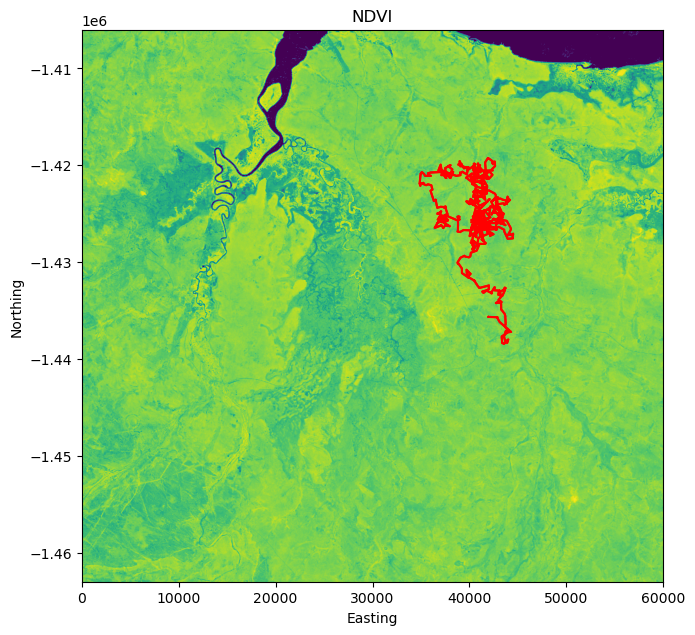

In [520]:
# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))

# Plot the NDVI raster
rasterio.plot.show(ndvi_landscape[which_ndvi,:,:], transform=raster_transform, ax=ax, cmap='viridis')

# Set the title and labels
ax.set_title('NDVI')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

# Number of simulated locations (to just get valid points)
n_sim_points = np.min([x[x>0].shape[0], y[y<0].shape[0]])
print(n_sim_points)

# Plot the simulated trajectory
plt.plot(x[1:n_sim_points], y[1:n_sim_points], color = 'red')
plt.plot(x[1:n_sim_points], y[1:n_sim_points], color = 'red')
plt.show()


# Plot with interactive map

We can also use the `folium` library to plot the trajectory on an interactive map. This is useful for checking the trajectory in more detail, as we can zoom in and out and pan around the map.

We used the ESRI World Imagery basemap, although other basemaps can be used (check the `folium` documentation for more options: https://python-visualization.github.io/folium/latest/user_guide/raster_layers/tiles.html).

In [521]:
# ESRI World Imagery basemap tile
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'

# Create a folium map with the ESRI World Imagery basemap (centred on starting location)
basemap = folium.Map(location=[-12.2995517, 134.3782028], tiles=tiles, attr='Esri', zoom_start = 10)

## Change projection of the trajectory

We will also reproject the observed data to the same projection as the basemap, so that we can overlay the observed data on the map as well.

We use the `pyproj` library to reproject the data. We will reproject the observed data to the same projection as the basemap, which is the World Geodetic System 1984 (WGS84) that used latitude and longitute coordinates, denoted by EPSG:4326.

In [522]:
# Create the reprojection function
coord_transformer = Transformer.from_crs('epsg:3112', 'epsg:4326')

# Observed data
# Convert the easting and northing coordinates to geographic coordinates
buffalo_lon, buffalo_lat = coord_transformer.transform(buffalo_df['x_'], buffalo_df['y_'])
print(buffalo_lon[1:4], buffalo_lat[1:4])
# Create a list of coordinate pairs (rather than separate lists)
buffalo_coordinates = [[lon, lat] for lon, lat in zip(buffalo_lon, buffalo_lat)]
print(buffalo_coordinates[1:4])

# Simulated data
# Convert the easting and northing coordinates to geographic coordinates
sim_lon, sim_lat = coord_transformer.transform(x[x>0], y[x>0])
# Create a list of coordinate pairs
sim_coordinates = [[lon, lat] for lon, lat in zip(sim_lon, sim_lat)]

[-12.2994049 -12.298934  -12.2992365] [134.3777718 134.37649   134.3770475]
[[-12.29940489999998, 134.3777718], [-12.298934000000022, 134.37649], [-12.29923650000004, 134.3770475]]


## Show the basemap with the trajectories

In [7]:
# Add the buffalo data
folium.PolyLine(
    locations=buffalo_coordinates,
    color='red',
    weight=2,
    opacity=1,
    tooltip='Buffalo trajectory'
).add_to(basemap)

# Add the simulated data
folium.PolyLine(
    locations=sim_coordinates,
    color='blue',
    weight=2,
    opacity=1,
    tooltip='Simulated trajectory'
).add_to(basemap)

# Plot the map
basemap

NameError: name 'buffalo_coordinates' is not defined

## Write the trajectory to a csv

Only run this once otherwise it will create duplicates

In [525]:
# output directory for saving trajectories
output_dir_traj = f'outputs/deepSSF_trajectories/{buffalo_id}'
os.makedirs(output_dir_traj, exist_ok=True)

# Combine vectors into a DataFrame
trajectory_df = pd.DataFrame({'x': x[x>0], 
                              'y': y[x>0], 
                              'hour': hour_t2[x>0], 
                              'yday': yday_t2[x>0], 
                              'bearing': bearing[x>0]
                              })

n_steps_actual = x[x>0].shape[0]

# Save the DataFrame to a CSV file
index = 1
csv_filename = f'{output_dir_traj}/deepSSF_id{buffalo_id}_{n_steps_actual}steps_{index}_{today_date}.csv'

# Check if the file already exists and find a new name if necessary
while os.path.exists(csv_filename):
    csv_filename = f'{output_dir_traj}/deepSSF_id{buffalo_id}_{n_steps_actual}steps_{index}_{today_date}.csv'
    index += 1

print(csv_filename)
trajectory_df.to_csv(csv_filename, index=True)

outputs/deepSSF_trajectories/2005/deepSSF_id2005_1000steps_1_2025-02-07.csv


# Multiple trajectories in a loop

In [ ]:
# -------------------------------------------------------------------------
# Setup parameters
# -------------------------------------------------------------------------
n_trajectories = 50
n_steps = 3000
starting_yday = 206

# -------------------------------------------------------------------------
# Looping over simulated individuals
# -------------------------------------------------------------------------

for j in range(1, n_trajectories+1):

    # Empty lists to store the x and y coordinates
    x = np.repeat(0., n_steps)
    y = np.repeat(0., n_steps)

    # Set the first entry as the starting location
    x[0], y[0] = start_x, start_y

    # Create sequence of steps
    step = range(1, n_steps)

    # Create an hour-of-day sequence and repeat it until it reaches n_steps.
    hour_t2 = np.resize(range(24), n_steps)

    # Convert hour-of-day values into sine and cosine components.
    hour_t2_sin = np.sin(2 * np.pi * hour_t2 / 24)
    hour_t2_cos = np.cos(2 * np.pi * hour_t2 / 24)

    # Create the day of the year sequences 
    # We want to index the NDVI layers into next year, which is why the ydays go above 365
    yday_t2 = np.repeat(range(starting_yday, starting_yday + 365), 24)
    yday_t2 = np.resize(yday_t2, n_steps)

    # Convert day-of-year values into sine and cosine components.
    yday_t2_sin = np.sin(2 * np.pi * yday_t2 / 365)
    yday_t2_cos = np.cos(2 * np.pi * yday_t2 / 365)

    # Initialise a bearing vector with zeroes for all simulation steps, 
    # which will be updated during the simulation.
    bearing = np.repeat(0., n_steps)

    # Convert lists to PyTorch tensors
    hour_t2_tensor = torch.tensor(hour_t2).float()
    hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
    hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
    yday_t2_tensor = torch.tensor(yday_t2).float()
    yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
    yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()  
    bearing_tensor = torch.tensor(bearing).float()

    # Stack tensors column-wise to create a tensor of shape [n_steps, 4]
    x2_full = torch.stack((hour_t2_sin_tensor, 
                        hour_t2_cos_tensor, 
                        yday_t2_sin_tensor, 
                        yday_t2_cos_tensor), dim=1)
    
    # Initialize variables to cache the previous yday and month index
    previous_yday = None


    # -------------------------------------------------------------------------
    # Simulation loop
    # -------------------------------------------------------------------------
    
    for i in range(1, n_steps):

        x_loc = x[i-1]
        y_loc = y[i-1]

        # calculate the bearing from the previous location
        if i > 1:
            bearing_rad = np.arctan2(y[i-1] - y[i-2], x[i-1] - x[i-2])
        else:
            # if it's the first step, sample a random bearing
            bearing_rad = np.random.uniform(-np.pi, np.pi)

        # Store the bearing in the vector
        bearing[i-1] = bearing_rad
        # print("Bearing[i-1]", bearing[i-1]) # Debugging print

        # Convert the bearing to a tensor and add dimensions for the batch and channel
        bearing_tensor = torch.tensor(bearing[i-1]).unsqueeze(0).unsqueeze(0)
        # print(bearing_tensor.shape) # Debugging print

        # Select the temporal features for the specific step
        x2 = x2_full[i-1,:].unsqueeze(dim=0)
        # print(x2) # Debugging print

        # Determine the month index based on the day of the year
        day_of_year = yday_t2[i-1]
        if day_of_year != previous_yday:
            month_index = day_to_month_index(day_of_year)
            previous_yday = day_of_year

        # print(f'Day of the year: {day_of_year}') # Debugging print
        # print(f'Month index: {month_index}') # Debugging print

        # Select the landscape rasters for the specific month
        landscape_raster_list = [ndvi_landscape_norm[month_index,:,:], 
                                canopy_landscape_norm, 
                                herby_landscape_norm, 
                                slope_landscape_norm]
        
        # Run the simulation function for the next step
        sim_outputs = simulate_next_step(landscape_raster_tensors=landscape_raster_list, 
                                        scalars_to_grid=x2,
                                        bearing=bearing_tensor,
                                        window_size=101,
                                        x_loc=x_loc,
                                        y_loc=y_loc,
                                        landscape_raster_transform=raster_transform)
        
        # Unpack the simulation outputs
        new_x, new_y, hab_log_prob, move_log_prob, step_log_prob, px, py = sim_outputs
        # print(f'New location in pixel coordinates           {px, py}') # Debugging print
        # print(f'New location in geographic coordinates      {new_x, new_y}\n') # Debugging print

        # Store the new x and y coordinates
        x[i] = new_x
        y[i] = new_y


    # -------------------------------------------------------------------------
    # Save the simulated trajectories
    # -------------------------------------------------------------------------

    # save the data frames individually
    # Combine vectors into a DataFrame
    trajectory_df = pd.DataFrame({'x': x[x>0], 
                                  'y': y[x>0], 
                                  'hour': hour_t2[x>0], 
                                  'yday': yday_t2[x>0], 
                                  'bearing': bearing[x>0]})
    
    n_steps_actual = x[x>0].shape[0]

    # Save the DataFrame to a CSV file
    index = j
    csv_filename = f'{output_dir_traj}/deepSSF_id{buffalo_id}_{n_steps_actual}steps_{index}_{today_date}.csv'

    # Check if the file already exists and find a new name if necessary
    while os.path.exists(csv_filename):
        csv_filename = f'{output_dir_traj}/deepSSF_id{buffalo_id}_{n_steps_actual}steps_{index}_{today_date}.csv'
        index += 1

    print(csv_filename)
    trajectory_df.to_csv(csv_filename, index=True)


outputs/deepSSF_trajectories/2005/deepSSF_id2005_1000steps_7_2025-02-07.csv
outputs/deepSSF_trajectories/2005/deepSSF_id2005_1000steps_8_2025-02-07.csv
outputs/deepSSF_trajectories/2005/deepSSF_id2005_1000steps_9_2025-02-07.csv
outputs/deepSSF_trajectories/2005/deepSSF_id2005_1000steps_10_2025-02-07.csv
outputs/deepSSF_trajectories/2005/deepSSF_id2005_1000steps_11_2025-02-07.csv
outputs/deepSSF_trajectories/2005/deepSSF_id2005_1000steps_12_2025-02-07.csv
outputs/deepSSF_trajectories/2005/deepSSF_id2005_1000steps_13_2025-02-07.csv
outputs/deepSSF_trajectories/2005/deepSSF_id2005_1000steps_14_2025-02-07.csv
outputs/deepSSF_trajectories/2005/deepSSF_id2005_1000steps_15_2025-02-07.csv
outputs/deepSSF_trajectories/2005/deepSSF_id2005_1000steps_16_2025-02-07.csv
outputs/deepSSF_trajectories/2005/deepSSF_id2005_1000steps_17_2025-02-07.csv
outputs/deepSSF_trajectories/2005/deepSSF_id2005_1000steps_18_2025-02-07.csv
outputs/deepSSF_trajectories/2005/deepSSF_id2005_1000steps_19_2025-02-07.csv
ou